# Analyzing and visualizing California insurance data
[Data about residential insurance](https://www.insurance.ca.gov/0400-news/0100-press-releases/2021/upload/nr117ResidentialInsurancePolicyAnalysisbyCounty12202021.pdf) sourced from the California Department of Insurance, described in the press release located [here](http://www.insurance.ca.gov/0400-news/0100-press-releases/2021/release117-2021.cfm).

In [27]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from carbonplan_styles.mpl import set_theme, colormaps
from carbonplan_styles.colors import light

## Read in the digitized data

In [2]:
df = pd.read_csv('../data/ca_insurance_digitized.csv')
_index = df['County'].values[::6].repeat(6)
df['County'] = _index
df = df.set_index(['County', 'Year'])

## Pass it to an xarray object to make it easier to work with

In [5]:
ds = df.to_xarray()
ds = ds.where(ds != '-', other=0)  
ds = ds.astype('int')

## Calculate three key metrics describing the state of the California insurance marketthat we'll use to track changes through time
* the count of policies within the FAIR plan
* the count of policies within the voluntary market
* the size of the total market (sum of the previous two)

In [7]:
ds['Total FAIR Plan'] = ds['California FAIR Plan - Number of New Policies']+ds['California FAIR Plan - Number of Renewed Policies']
ds['Total Voluntary Market'] = ds['Voluntary Market - Number of Renewed Policies']+ds['Voluntary Market - Number of Non-Renewed Policies Insurer-Initiated']
ds['Total market'] = ds['Total Voluntary Market'] + ds['Total FAIR Plan']

## Calculate the percentage dropped by insurance companies each year

In [35]:
ds['% dropped by insurer'] = ds['Voluntary Market - Number of Non-Renewed Policies Insurer-Initiated']/ds['Total Voluntary Market'] * 100

## Calculate the percentage of policies non-renewed by individuals that year

In [36]:
ds['% non-renewed by policy holders'] = ds['Voluntary Market - Number of Non-Renewed Policies Insured-Initiated']/ds['Total Voluntary Market'] * 100

## Calculate the of the total market covered by the state

In [37]:
ds['% market covered by state'] = ds['Total FAIR Plan']/ds['Total market'] * 100

## Plotting insurance activities for California
First load in the shapefile of California counties accessed from [California's Open Data Portal](https://data.ca.gov/dataset/ca-geographic-boundaries). 

In [41]:
ca_counties_shp = gpd.read_file('../data/CA_Counties/CA_Counties_TIGER2016.shp')

In [42]:
ca_counties_shp['NAME'] = ca_counties_shp['NAME'].str.upper()

In [43]:
shorthand_dict = {'% dropped by insurer': 'Drop',
                  '% non-renewed by policy holders': 'Left',
                  '% market covered by state': 'Fair'
                 }

for variable, shorthand in shorthand_dict.items():
    for year in np.arange(2015,2021):
        for county in ds.County.values:
            ca_counties_shp.loc[ca_counties_shp['NAME']==county, f'{shorthand}{year}'] = ds[variable].sel(County=county, Year=year)

In [44]:
matplotlib.rc("font", family="sans-serif")
matplotlib.rc("font", serif="Helvetica Neue")
matplotlib.rc("text", usetex="false")
matplotlib.rcParams.update({"font.size": 14, "svg.fonttype": "none"})

In [45]:
plot_dict = {'% dropped by insurer': [colormaps.fire_light, [0, 16]],
                  '% non-renewed by policy holders': [colormaps.wind_light, [7, 18]],
                  '% market covered by state': [colormaps.heart_light, [0, 32]]
                 }

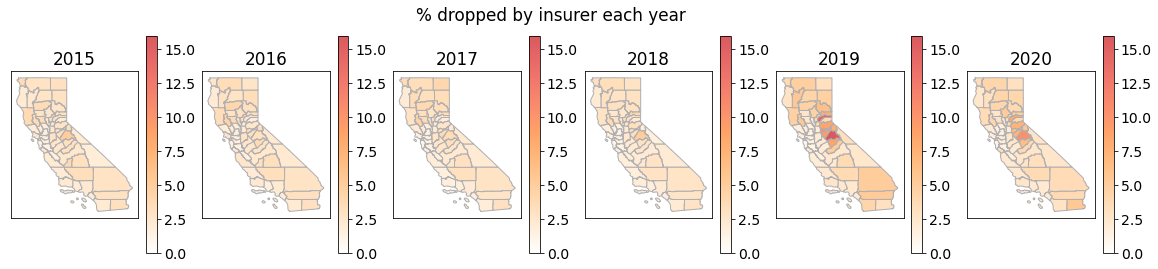

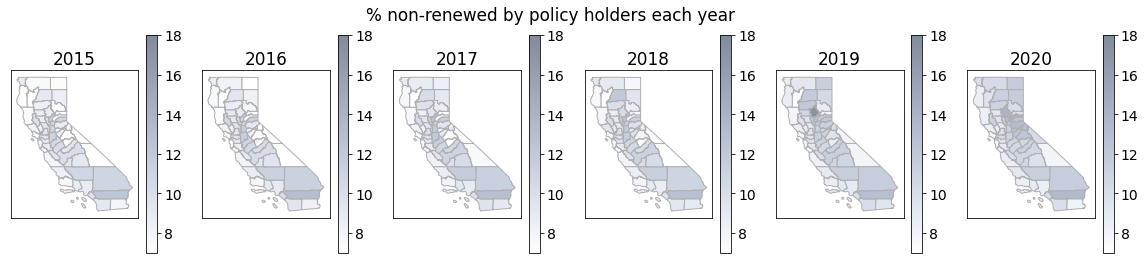

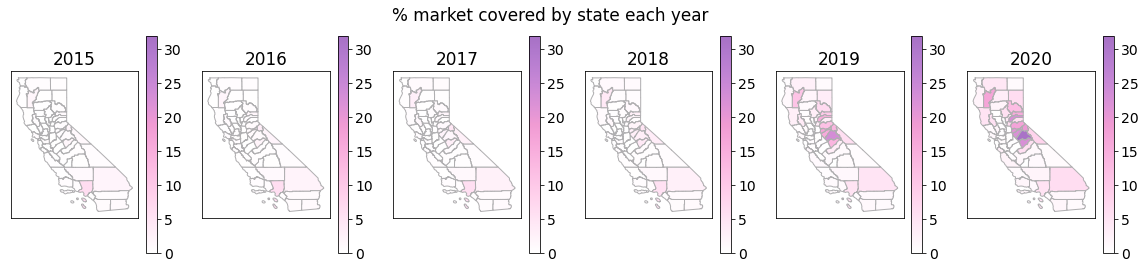

In [46]:
for variable, shorthand in shorthand_dict.items():
    fig, axarr = plt.subplots(ncols=6, figsize=(20,4), sharey=True)
    for i, year in enumerate(np.arange(2015,2021)):
        ax=axarr[i]
        plot = ca_counties_shp.plot(ax=ax, 
                                    column=f'{shorthand}{year}', 
                                    legend=True, 
                                    vmin=plot_dict[variable][1][0], 
                                    vmax=plot_dict[variable][1][1],
                                   cmap=plot_dict[variable][0], 
                                    edgecolor=light['muted'])
        ax.set_title(year)
        ax.set_xticks([])
        ax.set_yticks([])
    fig.suptitle(f'{variable} each year')
    plt.savefig(f'california_insurance_{shorthand}.svg', format='svg')